In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import os
from os.path import abspath, isfile, join
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
def rgba2rgb(image):
    if image.shape[2] == 3:
        return 1 - image
    alpha = image[:, :, 3]
    rgb = image[:, :, :3]
    black_spot = alpha == 0.0
    rgb += black_spot.reshape(rgb.shape[0], rgb.shape[1], 1)
    return rgb

def read_images_content(*path):
    filepath = abspath(join(*path))
    files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    images = [rgba2rgb(plt.imread(join(filepath, f))) for f in files]
    return images

IMG_SIZE = 64

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                # transforms.Grayscale(),
                                transforms.ToTensor(), 
                                # transforms.Normalize((0.5,), (0.5,))
                               ])

class PokemonDataset(Dataset):
    def __init__(self, *data_file, transform=None):
        self.data = read_images_content(*data_file)
        self.transform = transform

    def __getitem__(self, index: int) -> torch.Tensor:
        sample = self.data[index]
        if self.transform:
            sample = self.transform(np.uint8(sample * 255))
        return sample.squeeze()

    def __len__(self):
        return len(self.data)
    
images_data = PokemonDataset("pokemon-images-and-types", "images", "images", transform=transform)

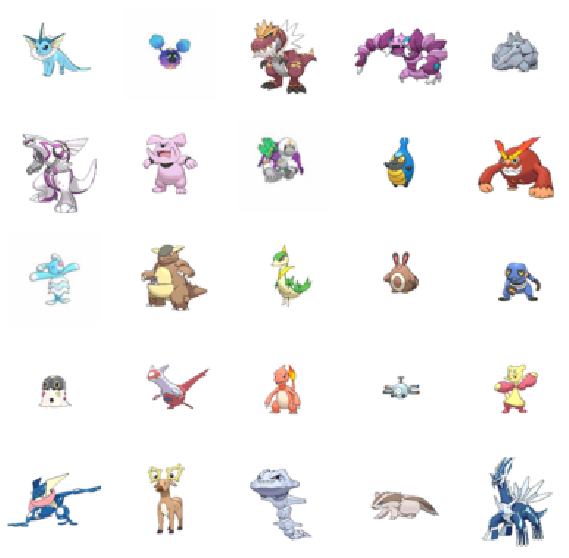

In [12]:
ind = np.random.randint(1, high=len(images_data), size=25)
pokemons = [images_data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(np.transpose(pokemons[i*5 + j], (1, 2, 0)), cmap='gray')
        # ax[i,j].imshow(pokemons[i*5 + j], cmap='gray')
        ax[i,j].axis('off')

In [4]:
stride=1
padd = 0
ks = 4
dil = 1
out_padd = 0
f = lambda x: (x-1)*stride - 2 * padd + dil * (ks-1) + out_padd + 1
m = [1, 4, 8, 16, 32]
[f(i) for i in m]

[4, 7, 11, 19, 35]

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

        self.fc_net = nn.Sequential(
            nn.Dropout(),
            nn.Linear(3 * (256 * 256), 3),
            nn.ReLU(inplace=True),
            nn.Linear(3, 1)
        )

    def forward(self, input):
        input = input.view(-1, 100, 1, 1)
        input = self.conv(input)
        # input = input.view(input.size(0), -1)
        # input = self.fc_net(input)
        return input


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True)
        )

        self.fc_net = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(8192, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = self.conv(input)
        input = input.view(input.size(0), -1)
        input = self.fc_net(input)
        return input

In [72]:
d = Discriminator()
g = Generator()
d(g(noise(1)))

tensor([[0.5832]], grad_fn=<SigmoidBackward>)

In [67]:
def noise(size, n_features=100):
    eps = torch.normal(0, 1, (size, n_features))
    # eps = torch.randn(size, n_features)
    if torch.cuda.is_available():
        return eps.cuda()
    return eps

def ones_tensor(size):
    t = torch.ones(size, 1)
    if torch.cuda.is_available():
        return t.cuda()
    return t

def zeros_tensor(size):
    t = torch.zeros(size, 1)
    if torch.cuda.is_available():
        return t.cuda()
    return t

In [51]:
discriminator = Discriminator()
generator = Generator()

learning_rate = 0.001
d_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optim = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

loss_function = nn.BCELoss()

def discriminator_step(optimizer, loss_function, true_data, fake_data):
    optimizer.zero_grad()
    output_true = discriminator(true_data)
    loss_true = loss_function(output_true, ones_tensor(true_data.size(0)))
    loss_true.backward()

    output_fake = discriminator(fake_data)
    loss_fake = loss_function(output_fake, zeros_tensor(fake_data.size(0)))
    loss_fake.backward()

    optimizer.step()
    return loss_true + loss_fake

def generator_step(optimizer, loss_function, fake_data):
    optimizer.zero_grad()
    output = discriminator(fake_data)
    loss = loss_function(output, ones_tensor(output.size(0)))
    loss.backward()
    # (loss + 0.01 * torch.mean(torch.pow(1-generator.sigma, 2))).backward()
    optimizer.step()
    return loss

In [52]:
def train_gan(loss_function, num_epochs=100):
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        for true_batch in dataloader:
            true_data = true_batch
            if torch.cuda.is_available():
                true_data = true_data.cuda()
            fake_data = generator(noise(true_data.size(0))).detach()
            discriminator_loss = discriminator_step(d_optim, loss_function, true_data, fake_data)
            fake_data = generator(noise(true_batch.size(0)))
            generator_loss = generator_step(g_optim, loss_function, fake_data)
            print(f'\r epoch: [{epoch+1}/{num_epochs}], discriminator: {discriminator_loss.data}, generator: {generator_loss.data}', end='')
        d_losses.append(float(discriminator_loss.data.cpu()))
        g_losses.append(float(generator_loss.data.cpu()))
    return d_losses, g_losses

In [73]:
num_epochs = 100
batch_size = 64
dataloader = torch.utils.data.DataLoader(images_data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

d_losses, g_losses = train_gan(loss_function, num_epochs)

 epoch: [100/100], discriminator: 0.4382966160774231, generator: 5.395668029785156432

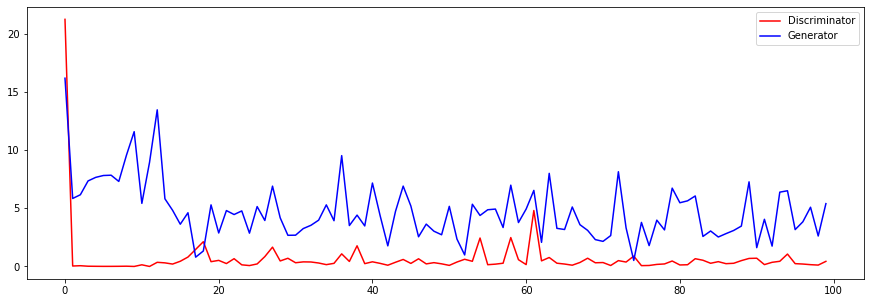

In [74]:
dat = pd.DataFrame({'d':d_losses, 'g':g_losses})
dat['epoch'] = np.arange(num_epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['d'], color='red', label='Discriminator')
ax.plot(dat['epoch'], dat['g'], color='blue', label='Generator')
ax.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

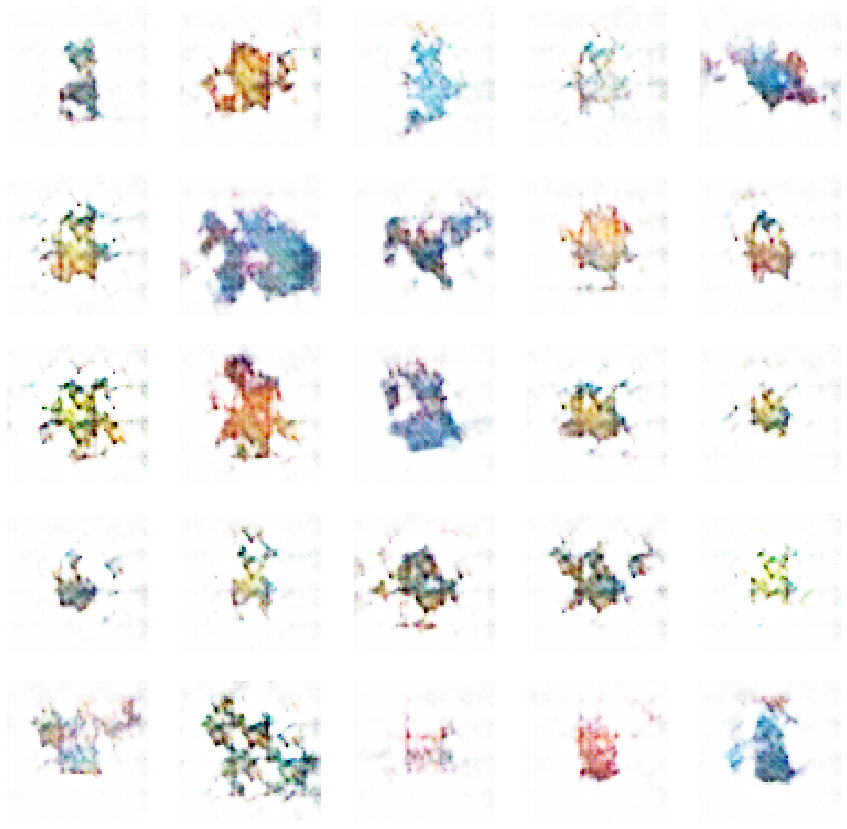

In [75]:
def image_grid_figure(sample, cols=5, rows=5, width=64, height=64, figsize=(15, 15), tags=None):
    fig, ax = plt.subplots(cols, rows, sharex='col', sharey='row', figsize=figsize)
    for i in range(cols):
        for j in range(rows):
            ax[i, j].imshow(np.transpose(sample[i * cols + j], (1, 2, 0)), cmap='gray')
            if tags is not None:
                ax[i, j].text(width // 2, -1.5, str(tags[i * cols + j]), ha='center')
            ax[i, j].axis('off')
    return fig

fake_digits = generator(noise(25)).data.cpu().numpy()
fig_grid = image_grid_figure(fake_digits)